# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [104]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from google.colab import drive


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [105]:
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/GOIT/DATA SCIENCE/goit-ds-hw07_bikes_rent.csv')
print(df.shape)
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(731, 13)
   season  yr  mnth  holiday  weekday  workingday  weathersit       temp     atemp      hum  windspeed(mph)  windspeed(ms)   cnt
0       1   0     1        0        6           0           2  14.110847  18.18125  80.5833       10.749882       4.805490   985
1       1   0     1        0        0           0           2  14.902598  17.68695  69.6087       16.652113       7.443949   801
2       1   0     1        0        1           1           1   8.050924   9.47025  43.7273       16.636703       7.437060  1349
3       1   0     1        0        2           1           1   8.200000  10.60610  59.0435       10.739832       4.800998  1562
4       1   0     1        0        3           1           1   9.305237  11.46350  43.6957       12.522300       5.597810  1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

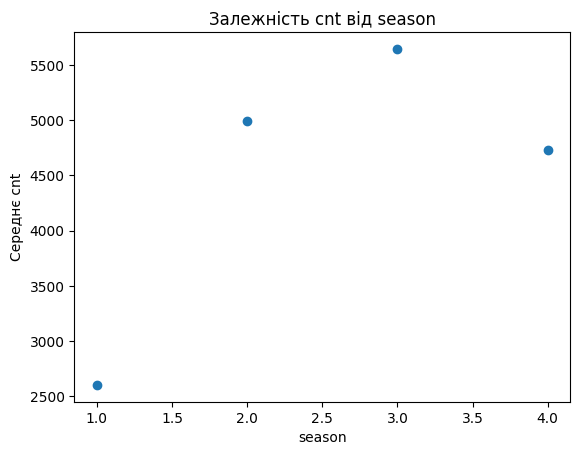

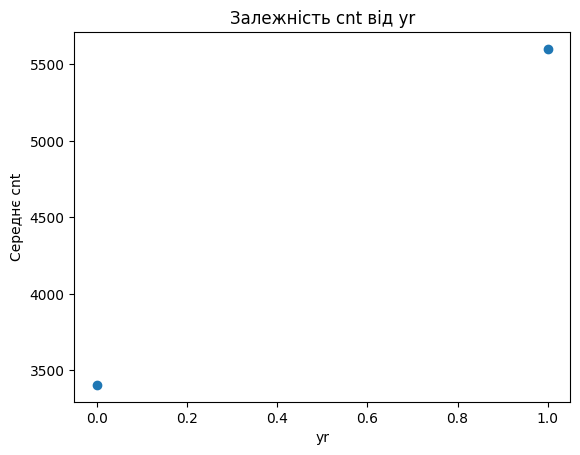

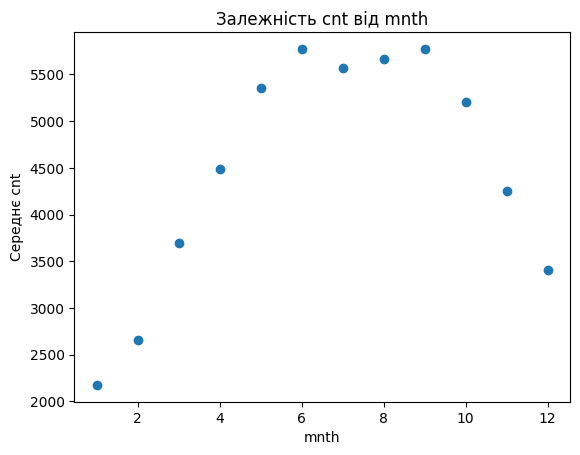

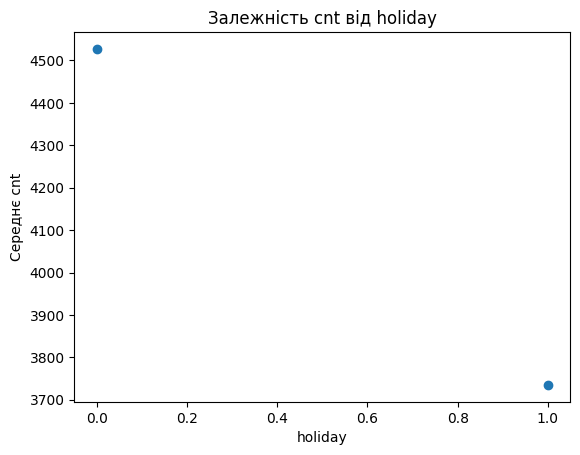

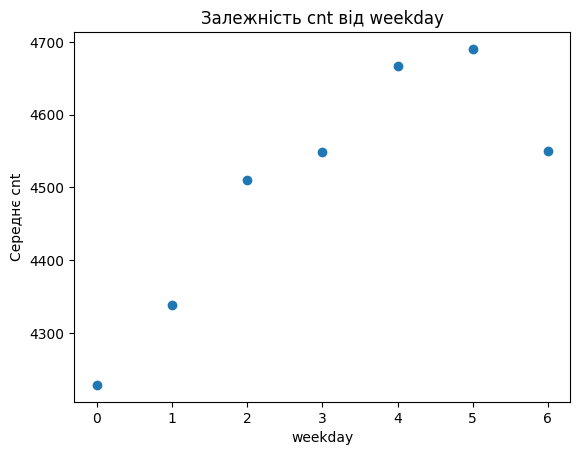

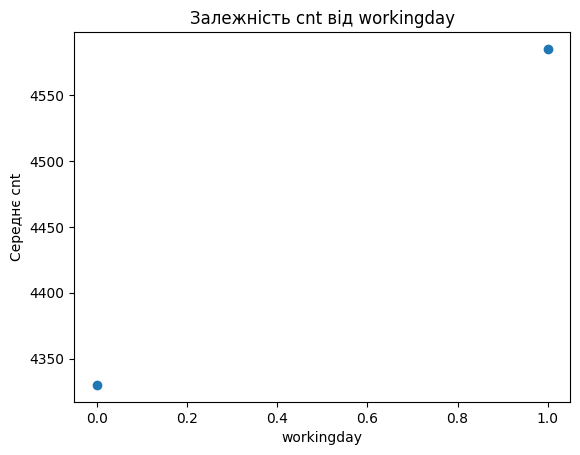

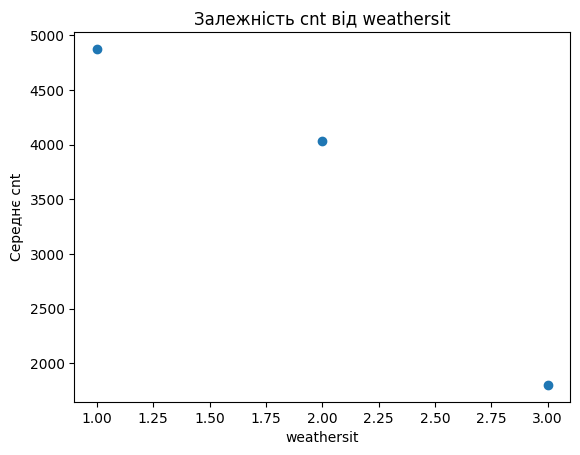

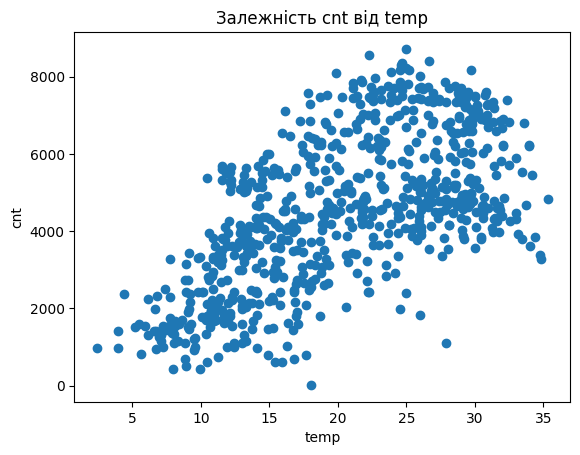

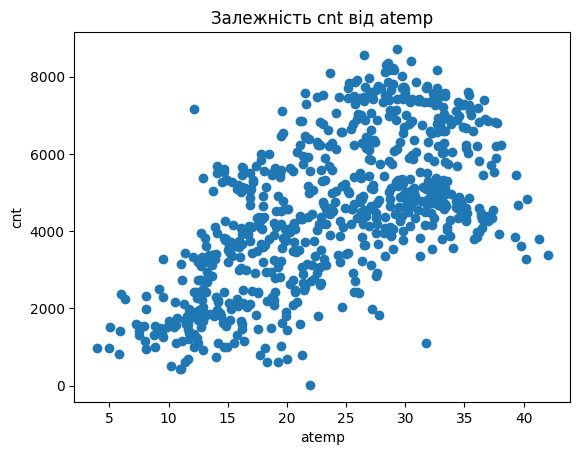

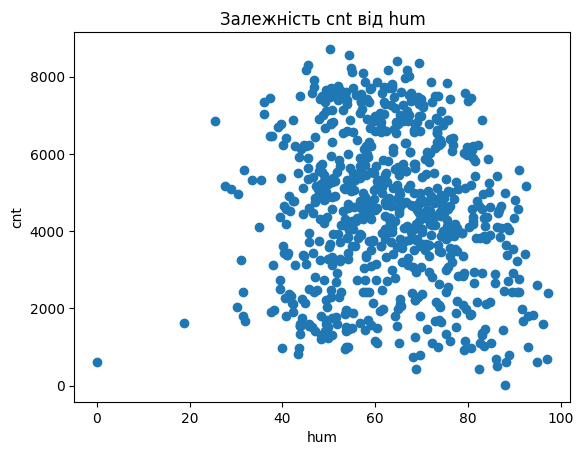

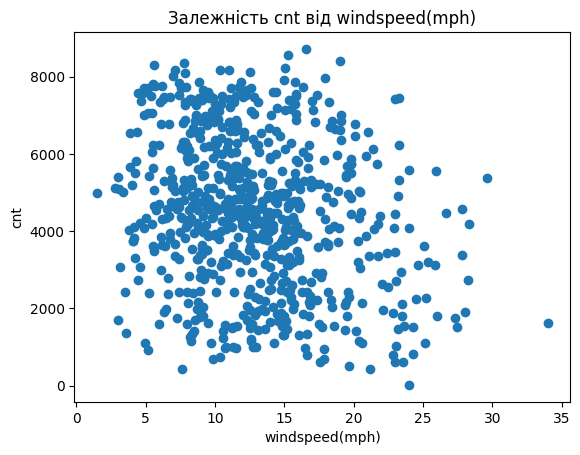

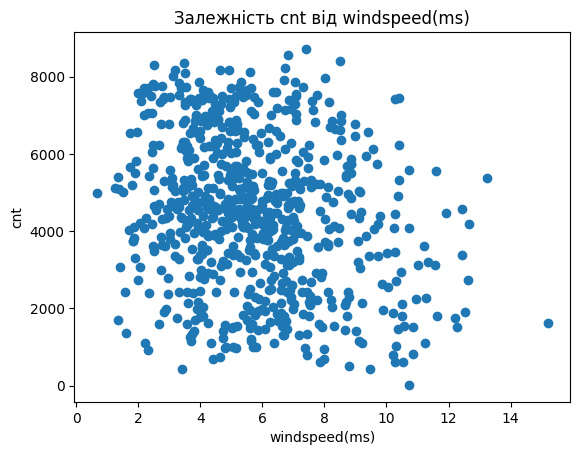

In [106]:
for column in df.columns:
  match column:
    case 'cnt':
      continue
    case 'temp' | 'atemp' | 'hum' | 'windspeed(mph)' | 'windspeed(ms)':
      plt.plot(df[column], df['cnt'], 'o')
      plt.ylabel('cnt')
      plt.xlabel(column)
      plt.title(f'Залежність cnt від {column}')
      plt.show()
    case _:
        grouped_data = df.groupby(column)['cnt'].mean()
        plt.plot(grouped_data.index, grouped_data.values,'o')
        plt.ylabel('Середнє cnt')
        plt.xlabel(column)
        plt.title(f'Залежність cnt від {column}')
        plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

**ВІДПОВІДЬ:**
1. Графік має характер парної степеневої функції з від'ємним аргументом y=-x^2i+c.
2. Графік залежності кількості прокатів від погодних умов, скоріш за все, є лінійним та від'ємнопропорційнним.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [107]:
correlations = df.iloc[:, :-1].corrwith(df['cnt'])
print(correlations)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [108]:
pd.set_option('display.max_columns', None)  # Показати всі стовпці
pd.set_option('display.width', 1000)
correlation_columns = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
correlation_matrix = df[correlation_columns].corr()

print(correlation_matrix)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)       cnt
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944  0.627494
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643  0.631066
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489 -0.100659
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000 -0.234545
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000 -0.234545
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545  1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [109]:
df_mean = df.mean()
print(df_mean)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [110]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [111]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [112]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

w = model.coef_
feautre_names = df_shuffled.columns[:-1]
w_df = pd.DataFrame(w, index=feautre_names, columns=['w'])

print(w_df)

                           w
season          5.708638e+02
yr              1.021965e+03
mnth           -1.413017e+02
holiday        -8.675934e+01
weekday         1.372251e+02
workingday      5.639188e+01
weathersit     -3.302265e+02
temp            3.674837e+02
atemp           5.855494e+02
hum            -1.456143e+02
windspeed(mph)  1.245714e+13
windspeed(ms)  -1.245714e+13


## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [113]:
for feature, weight in zip(df.columns[:-1], w):
    print(f"{feature}: {weight}")

season: 570.8637960129914
yr: 1021.9653779400622
mnth: -141.3017451148728
holiday: -86.7593446245368
weekday: 137.22506441350538
workingday: 56.391881775973005
weathersit: -330.2264620440312
temp: 367.48373260182126
atemp: 585.5493861188597
hum: -145.61430569885857
windspeed(mph): 12457138390688.885
windspeed(ms): -12457138390887.346


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [114]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X, y)

lasso_w = lasso_model.coef_
for feature, weight in zip(df.columns[:-1], lasso_w):
    print(f"{feature}: {weight}")

season: 565.3216570612018
yr: 1020.2561015161349
mnth: -133.89500587503778
holiday: -86.66727917692955
weekday: 138.21983421616665
workingday: 55.87035675016136
weathersit: -332.69555472955386
temp: 377.3683235504604
atemp: 575.6727820441071
hum: -144.87124671813464
windspeed(mph): -198.10557751370823
windspeed(ms): -2.8284808432494093e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [115]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X, y)

ridge_w = ridge_model.coef_
for feature, weight in zip(df.columns[:-1], ridge_w):
    print(f"{feature}: {weight}")

season: 563.0645722520181
yr: 1018.9483787875305
mnth: -131.87332028247715
holiday: -86.74609799709232
weekday: 138.00511117871918
workingday: 55.90311037506467
weathersit: -332.34978849907367
temp: 386.45788919190807
atemp: 566.3470470600669
hum: -145.07132729867195
windspeed(mph): -99.25944108179067
windspeed(ms): -99.25944115434177


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [116]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:

    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X, y)
    coefs_lasso.append(lasso_model.coef_)

    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X, y)
    coefs_ridge.append(ridge_model.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

lasso_df = pd.DataFrame(coefs_lasso, columns=df.columns[:-1],index=[f"alpha={alpha}" for alpha in alphas])
ridge_df = pd.DataFrame(coefs_ridge, columns=df.columns[:-1],index=[f"alpha={alpha}" for alpha in alphas])

print("Ваги Lasso:")
print(lasso_df)
print("\nВаги Ridge:")
print(ridge_df)

Ваги Lasso:
               season           yr        mnth    holiday     weekday  workingday  weathersit        temp       atemp         hum  windspeed(mph)  windspeed(ms)
alpha=1    560.241616  1019.463494 -128.730627 -86.152781  137.347894   55.212371 -332.369857  376.363236  576.530794 -144.129155     -197.139689  -2.805140e-08
alpha=51   410.969632   977.019409   -0.000000 -53.448969   91.943437   17.537212 -318.125568  322.829934  610.031512  -91.068962     -145.066095  -2.298929e-08
alpha=101  370.077089   935.945490    0.000000 -12.161936   48.888634    0.000000 -308.805664  269.417263  632.502623  -27.504288      -93.774904  -2.416579e-08
alpha=151  332.835717   891.870058    0.000000  -0.000000    0.000000    0.000000 -279.616688  211.052030  662.920880   -0.000000      -50.155147  -2.627899e-08
alpha=201  298.134448   845.652857    0.000000  -0.000000    0.000000    0.000000 -235.571345  124.144807  725.379483   -0.000000      -12.646177  -2.787757e-08
alpha=251  258.927201 

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

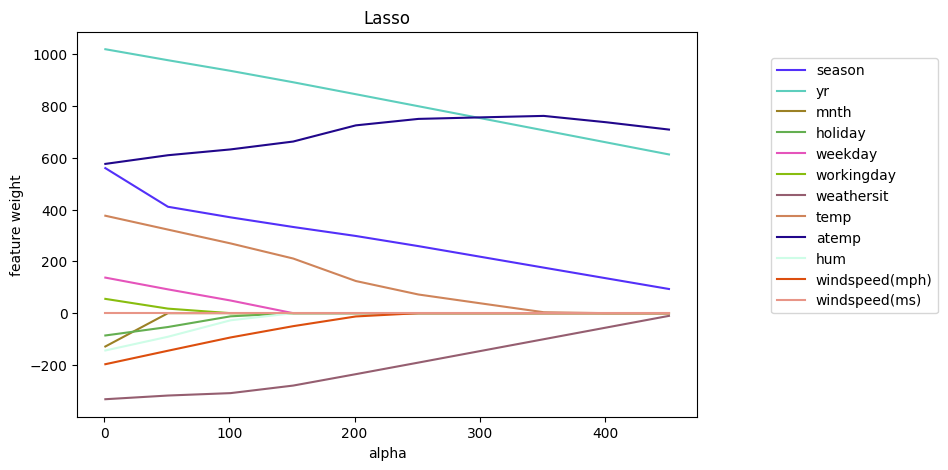

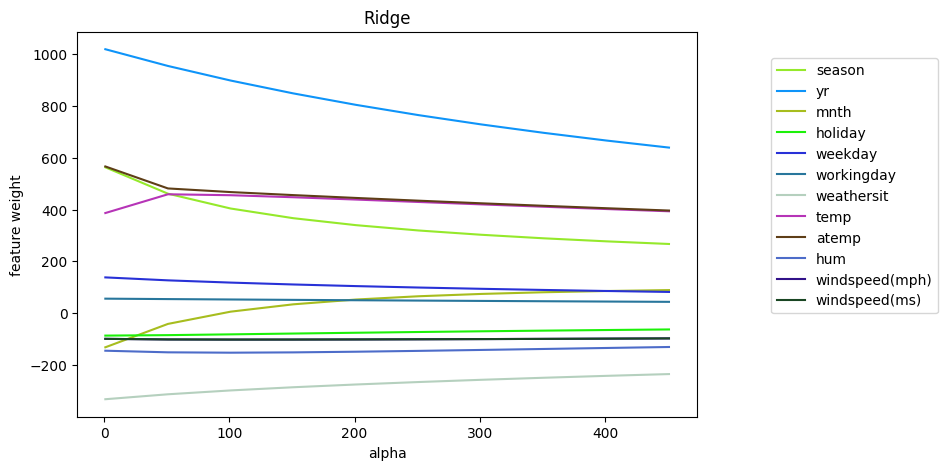

In [117]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

**ВІДПОВІДІ:**
1. Lasso.
2. Коли alpha стає дуже великим, то всі значення вагів зводяться до нуля. Посилення регуляції сприяє зануленню менш значушчих вагів. Модель прагне зменшити всі ваги до нуля щоб відповідати обмеженням L1-регуляції.
3. Так, Lasso обирає лише одну ознаку між лінійно залежними, а другу зануляє. Ridgle, натомість, не виключає жодної ознаки, а зменшує ваги обох завдяки L2-регуляції.
4. Lasso.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [134]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xscale("log")

    plt.grid()
    plt.show()

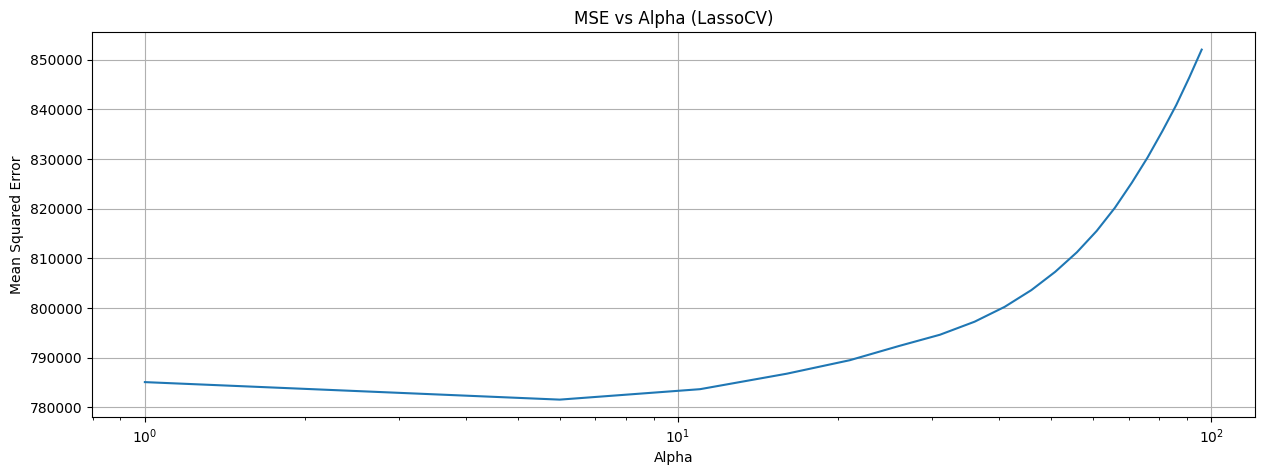

Вибране значення alpha: 6
Коефіцієнти моделі:
season: 532.0189828413535
yr: 1015.0602226430595
mnth: -100.03952614356629
holiday: -83.29395987529904
weekday: 132.50446549095795
workingday: 51.557085614073735
weathersit: -330.5598567399817
temp: 370.67985503003405
atemp: 581.396931065498
hum: -140.00740550068844
windspeed(mph): -191.77140847135036
windspeed(ms): -2.6854702314758792e-08


In [138]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3).fit(X, y)
mse_mean = regressor.mse_path_.mean(axis=1)

create_plot(
    data=list(zip(regressor.alphas_, mse_mean)),
    title="MSE vs Alpha (LassoCV)",
    xlabel="Alpha",
    ylabel="Mean Squared Error"
)

print("Вибране значення alpha:", regressor.alpha_)
print("Коефіцієнти моделі:")
for feature, coef in zip(df.columns[:-1], regressor.coef_):
    print(f"{feature}: {coef}")

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Значення alpha для кожного розбиття:
Розбиття 1: alpha = 6
Розбиття 2: alpha = 1
Розбиття 3: alpha = 51


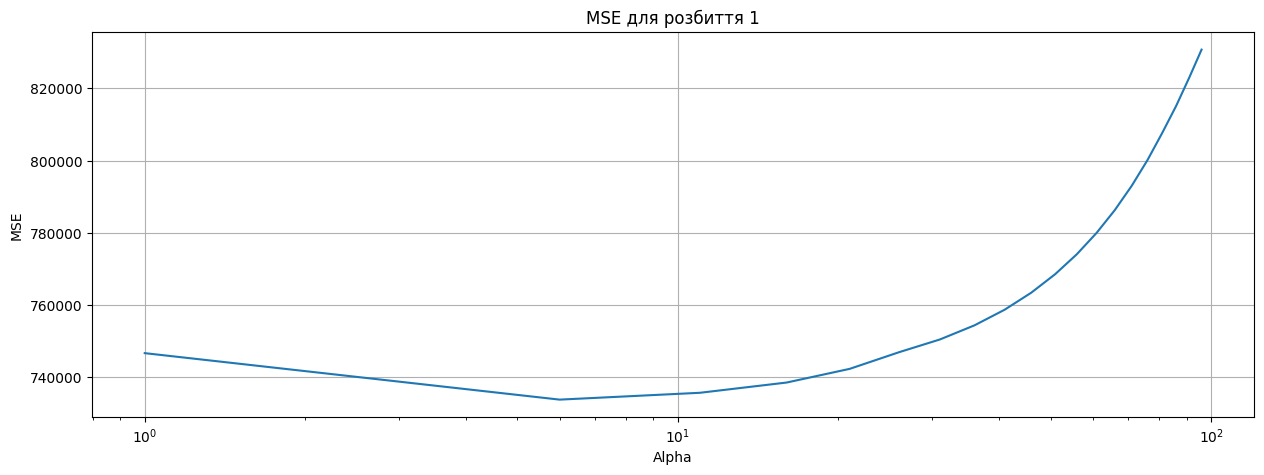

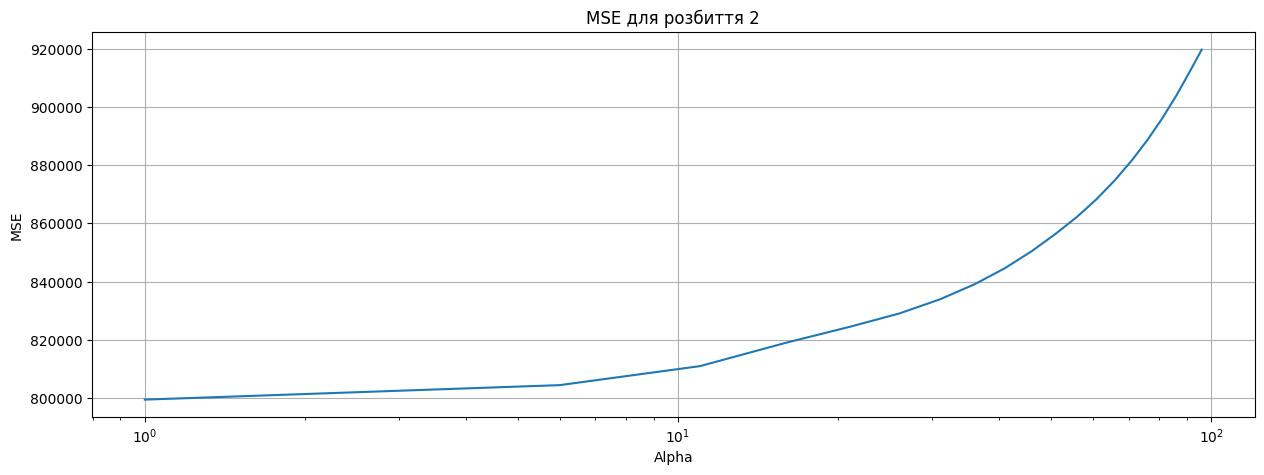

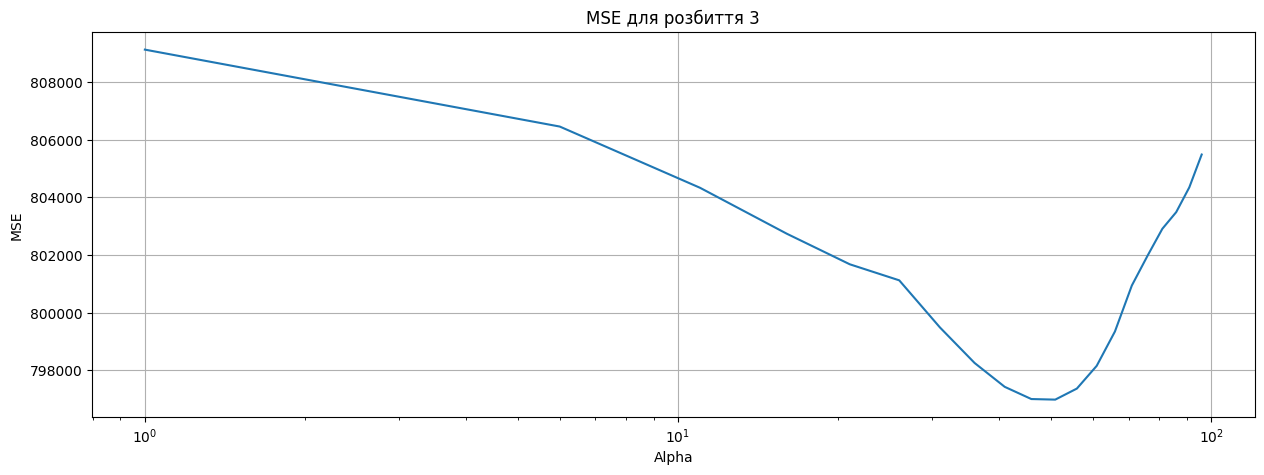

In [145]:
optimal_alphas = [regressor.alphas_[np.argmin(regressor.mse_path_[:, i])] for i in range(regressor.mse_path_.shape[1])]
# print(regressor.alphas_)
# print(regressor.mse_path_)
# print(optimal_alphas)

print("Значення alpha для кожного розбиття:")
for idx, alpha in enumerate(optimal_alphas):
    print(f"Розбиття {idx + 1}: alpha = {alpha}")

for i in range(regressor.mse_path_.shape[1]):
    create_plot(
        data=list(zip(regressor.alphas_, regressor.mse_path_[:, i])),
        title=f"MSE для розбиття {i + 1}",
        xlabel="Alpha",
        ylabel="MSE"
    )

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

Отже, за останню навчену модель вважатиму модель з завдання 8. Тоді ознаки: season, yr, temp, atemp. Для season вартість 4 свідчить про спад cnt. Для yr залежність зростаюча і може бути лінійною, але на графіку лише 2 пункти. temp i atemp мають зростаючу, швидше за все лінійну залежність. Зростаючу лінійну залежність у цих кореляціях можливо допустити лише при відповідному ступені апроксимації. Особисто для мене більш показовими були кореляції у завданні 2. Ствердження описане у запитанні є цілком логічним.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

Отже, за останню навчену модель вважатиму модель з завдання 8. Тоді ознаки: mnth, weathersit, hum, windspeed(mph). Тут ситуація прозора лише для weathersit: залежність є, може бути лінійною і оберненопропорційною. cnt=f(mnth) точно не лінійна. А для hum і windspeed(mph) не вдається неозброєним оком спостерігати залежність. Якщо звернути увагу на кореляцію з завдання 2, то твердження у запитанні правдиве не для всіх ознак. Щоб твердження було вірним, необхідно замінити mnth на holiday. Тоді це можна підтвердити теж особистим досвідом: люди менше їздять на велосипеді, коли немає свят, погана погода, висока вологість або сильний вітер.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

Отже, за останню навчену модель вважатиму модель з завдання 8. windspeed(ms) має найнижчий коефіцієнт, тому що  у нашій моделі він не має унікального впливу на результат. Його замінює windspeed(mph). Наступний найближчий до нуля workingday. І він дійсно має найслабшу кореляцію з cnt. Тому так, він має найменший вплив.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.